In [1]:
# Imports.
import naclib.stpol
import naclib.util
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Input.
# Spot locations in df_locs (with columns 'x' and 'y') are corrected using coefficients in df_coefs.
df_locs = pd.read_csv('../example/nanoruler_data_c2.csv')
df_locs_ref = pd.read_csv('../example/nanoruler_data_c1.csv')
df_coefs = pd.read_csv('../example/STcoefficients.csv')
fig_size = [512, 256]  # Original image size, needed for rescaling to unit circle.

# Output.
output_locs = '../example/locs_corrected.csv'

df_locs

,Unnamed: 0,id,frame,x [nm],y [nm],sigma [nm],intensity [photon],offset [photon],bkgstd [photon],uncertainty_xy [nm]
0,0,0,138,59199.58,28022.39,0.0,1506,104,0,8.20
1,1,1,138,37345.20,27991.27,0.0,2019,122,0,6.78
2,2,2,138,13000.29,27869.14,0.0,974,113,0,12.21
3,3,3,138,41951.28,27288.29,0.0,1741,116,0,7.54
4,4,4,138,5775.36,26863.39,0.0,1073,98,0,10.67
...,...,...,...,...,...,...,...,...,...,...
1080654,1080654,1080654,9956,14517.18,1601.28,0.0,1115,109,0,17.65
1080655,1080655,1080655,9956,48133.95,1418.13,0.0,1554,103,0,12.89
1080656,1080656,1080656,9956,55450.41,1132.08,0.0,1853,111,0,11.35
1080657,1080657,1080657,9956,12061.38,1216.66,0.0,1369,102,0,14.35


In [3]:
# Read input data; scale to unit circle.
pixel_size = 125  # in nm/px
locs_raw = np.zeros((len(df_locs), 2))
locs_raw[:, 0] = df_locs['x [nm]']/pixel_size
locs_raw[:, 1] = df_locs['y [nm]']/pixel_size
locs, scale = naclib.util.loc_to_unitcircle(locs_raw, fig_size)
df_S = df_coefs[df_coefs['type'] == 'S']
df_T = df_coefs[df_coefs['type'] == 'T']
a_S = {row['term']: row['value'] for _, row in df_S.iterrows()} 
a_T = {row['term']: row['value'] for _, row in df_T.iterrows()}
j_max_S = df_S['term'].max()
j_max_T = df_T['term'].max()

# Get correction field.
stpol = naclib.stpol.STPolynomials(j_max_S=j_max_S, j_max_T=j_max_T)
P = stpol.get_field(locs, a_S, a_T)

# Correct spot locations, scale back from unit circle to original scale, and save.
locs_corrected = locs + P
df_locs_corrected = df_locs.copy()
locs_scaled_corrected = naclib.util.unitcircle_to_loc(locs_corrected, fig_size)
df_locs_corrected['x [nm]'] = locs_scaled_corrected[:, 0] * pixel_size
df_locs_corrected['y [nm]'] = locs_scaled_corrected[:, 1] * pixel_size
df_locs_corrected = df_locs_corrected[df_locs_corrected['x [nm]'] > 0]
df_locs_corrected = df_locs_corrected[df_locs_corrected['x [nm]'] < fig_size[0] * pixel_size]
df_locs_corrected = df_locs_corrected[df_locs_corrected['y [nm]'] > 0]
df_locs_corrected = df_locs_corrected[df_locs_corrected['y [nm]'] < fig_size[1] * pixel_size]
df_locs_corrected.to_csv(output_locs)

df_locs_corrected

,Unnamed: 0,id,frame,x [nm],y [nm],sigma [nm],intensity [photon],offset [photon],bkgstd [photon],uncertainty_xy [nm]
0,0,0,138,59268.375436,28042.422598,0.0,1506,104,0,8.20
1,1,1,138,37371.623192,28048.288033,0.0,2019,122,0,6.78
2,2,2,138,12958.994857,27935.311984,0.0,974,113,0,12.21
3,3,3,138,41985.073524,27338.090699,0.0,1741,116,0,7.54
4,4,4,138,5713.385199,26922.817286,0.0,1073,98,0,10.67
...,...,...,...,...,...,...,...,...,...,...
1080654,1080654,1080654,9956,14466.361984,1529.650403,0.0,1115,109,0,17.65
1080655,1080655,1080655,9956,48182.541536,1316.522660,0.0,1554,103,0,12.89
1080656,1080656,1080656,9956,55517.125908,1038.598993,0.0,1853,111,0,11.35
1080657,1080657,1080657,9956,11999.294847,1144.438609,0.0,1369,102,0,14.35


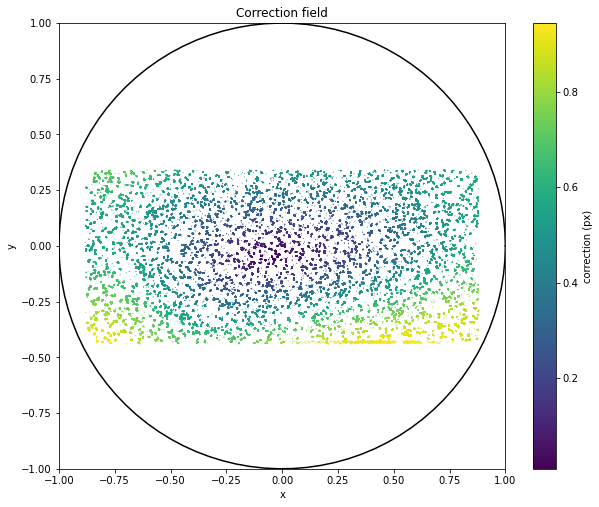

In [4]:
# Plot correction field.
magnitude = np.hypot(P[:, 0], P[:, 1]) * scale
plt.figure(figsize=(10, 8.2))
q = plt.quiver(locs[:, 0], locs[:, 1], P[:, 0], P[:, 1], magnitude, pivot='mid')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), c='k')
clb = plt.colorbar(q)
plt.title('Correction field')
plt.xlabel('x')
plt.ylabel('y')
clb.set_label('correction (px)')
plt.axis('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.show()

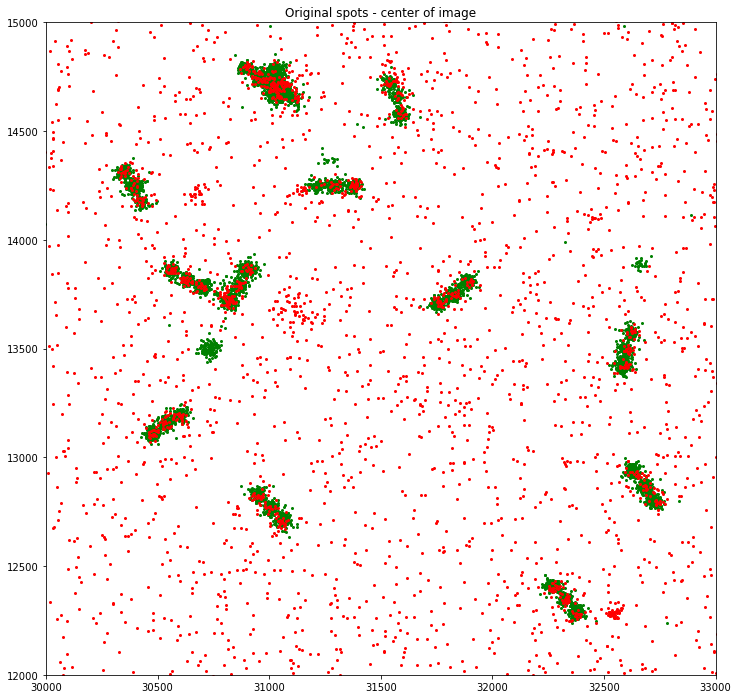

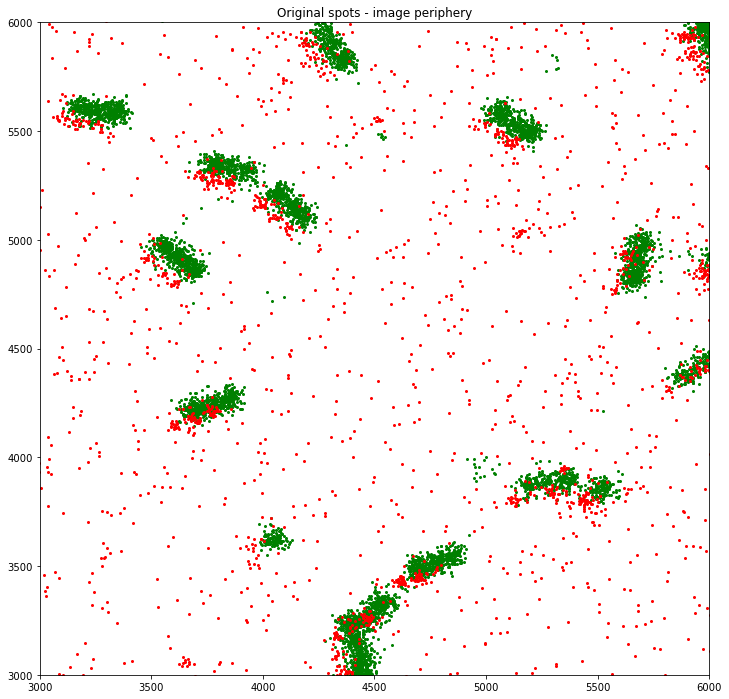

In [5]:
# Show localization improvement
# Original grid.
plt.figure(figsize=(12, 12))
plt.title('Original spots - center of image')
plt.scatter(df_locs['x [nm]'], df_locs['y [nm]'], c='g', s=4)
plt.scatter(df_locs_ref['x [nm]'], df_locs_ref['y [nm]'], c='r', s=4)
plt.xlim((30000, 33000))
plt.ylim((12000, 15000))
plt.show()
plt.close()

plt.figure(figsize=(12, 12))
plt.title('Original spots - image periphery')
plt.scatter(df_locs['x [nm]'], df_locs['y [nm]'], c='g', s=4)
plt.scatter(df_locs_ref['x [nm]'], df_locs_ref['y [nm]'], c='r', s=4)
plt.xlim((3000, 6000))
plt.ylim((3000, 6000))
plt.show()
plt.close()

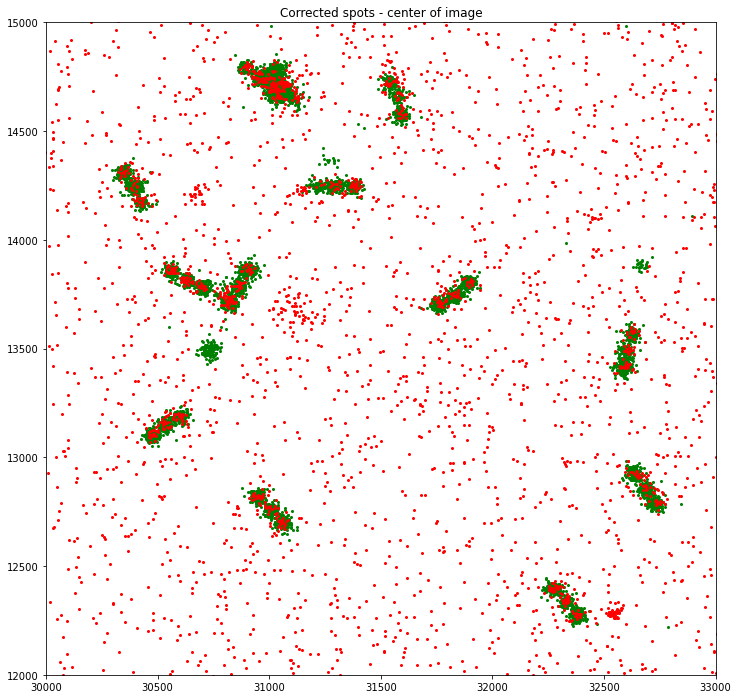

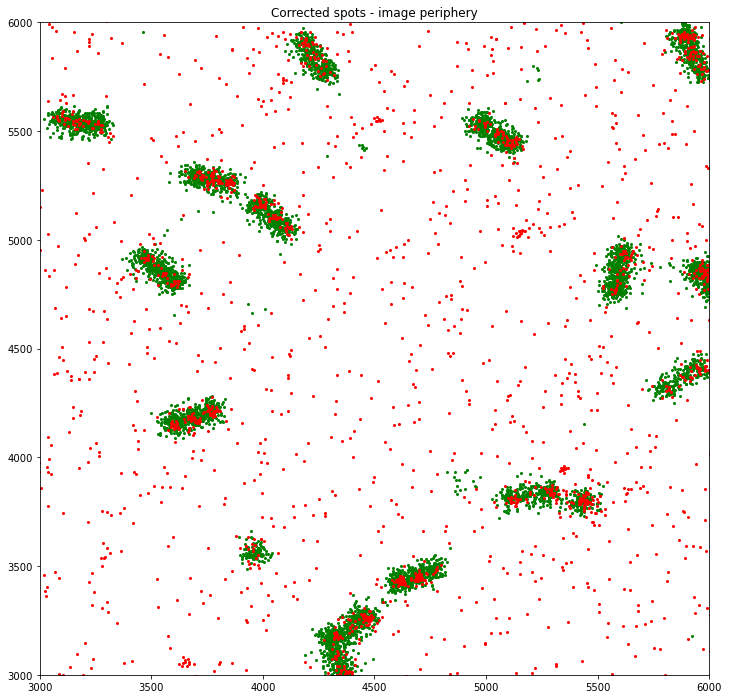

In [6]:
# Corrected grid.
plt.figure(figsize=(12, 12))
plt.title('Corrected spots - center of image')
plt.scatter(df_locs_corrected['x [nm]'], df_locs_corrected['y [nm]'], c='g', s=4)
plt.scatter(df_locs_ref['x [nm]'], df_locs_ref['y [nm]'], c='r', s=4)
plt.xlim((30000, 33000))
plt.ylim((12000, 15000))
plt.show()
plt.close()

plt.figure(figsize=(12, 12))
plt.title('Corrected spots - image periphery')
plt.scatter(df_locs_corrected['x [nm]'], df_locs_corrected['y [nm]'], c='g', s=4)
plt.scatter(df_locs_ref['x [nm]'], df_locs_ref['y [nm]'], c='r', s=4)
plt.xlim((3000, 6000))
plt.ylim((3000, 6000))
plt.show()
plt.close()